## Consistency with smartseq data:

1. Contaminated programs (8)
2.  exhausted vs. memory analysis (2)
3. repeating the ranksum tests on treatments subgroups (2)
4. robust test of differential expression by discovering and cross validation (3)
5. identify the % of organ cells in each biopsy (5)
6. plot a histogram of the number of T-cells; Myeloids and B-cells for example across the entire cohort (6)
7. Comparing non-responder immune markers with smartseq2 study (7)



In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *
import scipy.stats as stats
import warnings 
warnings.filterwarnings("ignore")

In [2]:
def get_pvals(group_fractions):
    pvals = []
    for cluster in set(group_fractions["cluster"]):
        cluster_df = group_fractions[group_fractions["cluster"] == cluster]
        R_fractions = cluster_df[cluster_df["Response"] == 'R']['sample_fraction'].values
        NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['sample_fraction'].values
        res = ranksums(R_fractions, NR_fractions)[1]
        pvals.append([cluster, res])
    pvals = np.array(pvals)

    # Correct pvals
    corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T
    return pvals, corrected_pvals

# 1. Contaminated programs (8)

In [104]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21'

selected_K = 30
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '30'

In [105]:
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
normalized_usage_matrix.head()

normalized_usage_matrix = normalized_usage_matrix.reset_index()

normalized_usage_matrix['sample'] = normalized_usage_matrix['index'].apply(lambda x: x.split('_')[0])
normalized_usage_matrix['barcode'] = normalized_usage_matrix['index'].apply(lambda x: x.split('_')[1])
normalized_usage_matrix = normalized_usage_matrix.drop(columns=['index'])#.set_index(['sample', 'barcode'])

See the % of cells in each usage level in program #14:

In [106]:
PROG_IDX = 14
{f'Usage {round(k*100)}%': f'{round(v/len(normalized_usage_matrix)*100,2)}% of the cells' for k,v in sort_dic(Counter(round(normalized_usage_matrix[PROG_IDX], 1))).items()}

{'Usage 0%': '85.12% of the cells',
 'Usage 10%': '10.64% of the cells',
 'Usage 20%': '2.27% of the cells',
 'Usage 30%': '0.88% of the cells',
 'Usage 40%': '0.37% of the cells',
 'Usage 50%': '0.27% of the cells',
 'Usage 60%': '0.25% of the cells',
 'Usage 70%': '0.14% of the cells',
 'Usage 80%': '0.06% of the cells',
 'Usage 90%': '0.01% of the cells',
 'Usage 100%': '0.0% of the cells'}

Analyze these cells:

In [107]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22/cohort_normalized_16.3.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)

In [133]:
# take cells with % usage > 0.2 in program #14:
prog_idx = 14
usage_threshold = 0.2

identifiers = normalized_usage_matrix[normalized_usage_matrix[prog_idx]>usage_threshold]
subcohort = tumor_cohort.get_subset_by_identifiers(identifiers['sample'], identifiers.barcode)
print(f'number of cells in subcohort: {subcohort.number_of_cells}')

number of cells in subcohort: 4292


In [134]:
# print(subcohort.cells_information.getattr('cell_type_list'))
# print(subcohort.cells_information.getattr('conflict_related_cell_types'))
print(f'1. apoptosis cells: {sum(subcohort.cells_information.getattr("is_apoptosis"))}')
print(f'2. immune cells: {sum(subcohort.cells_information.getattr("is_immune"))}')
print(f'3. tumor cells: {sum(subcohort.cells_information.getattr("is_cancer"))}')
print(f'4. tumor & immune conflicts: {sum(subcohort.cells_information.getattr("cancer_immune_conflict"))}')
print(f'5. doublets: {sum(subcohort.cells_information.getattr("is_doublet"))}')
print(f'6. lymphoids: {sum(subcohort.cells_information.getattr("is_lymphoid"))}')
print(f'7. myeloids: {sum(subcohort.cells_information.getattr("is_myeloid"))}')
print(f'8. CelBender_empty: {sum(subcohort.cells_information.getattr("is_CelBender_empty"))}')
print(f'9. stromal: {sum(subcohort.cells_information.getattr("is_stromal"))}')
print(f'10. epithelial: {sum(subcohort.cells_information.getattr("is_epithelial"))}')
print(f'11. should_be_removed: {sum(subcohort.cells_information.getattr("should_be_removed"))}')
print(f'12. Comments: {dict(Counter(subcohort.cells_information.getattr("comment")))}')
# print(f'13 {(subcohort.cells_information.getattr("is_responder"))}')

1. apoptosis cells: 0
2. immune cells: 0
3. tumor cells: 4292
4. tumor & immune conflicts: 0
5. doublets: 1
6. lymphoids: 0
7. myeloids: 0
8. CelBender_empty: 229
9. stromal: 0
10. epithelial: 0
11. should_be_removed: 0
12. Comments: {None: 3540, '10.6.21 tumor cells with immune markers that may be on tumor cells': 752}


#  2.  Exhausted vs. Memory (2)


#### part 1: Find two clusters of CD8 and conduct differential expression analysis:

In [12]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22/immune_cells_normalized_16.3.22_4k_genes.pkl'
print(f'Loading cohort from:\n{COHORT_PATH}')

cohort = pickle.load(open(INPUT_PATH, 'rb'))
CD8_cohort = get_requested_subset(cohort, 'CYTOTOXIC_T_CELLS')


Loading cohort from:
/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22/immune_cells_normalized_16.3.22_4k_genes.pkl
Will be performed on cytotoxic T cells


In [84]:
CD8_k_2_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'
clustering_mapping = pd.read_csv(CD8_k_2_PATH).drop(columns=['index'])
Cluster_1_df = clustering_mapping[clustering_mapping.Cluster==1]
Cluster_2_df = clustering_mapping[clustering_mapping.Cluster==2]

In [20]:
cohort_cluster1 = CD8_cohort.get_subset_by_identifiers(Cluster_1_df['Sample'], Cluster_1_df['Barcode'])
cohort_cluster2 = CD8_cohort.get_subset_by_identifiers(Cluster_2_df['Sample'], Cluster_2_df['Barcode'])

cluster_1_markers = find_satisfying_list_of_markers_in_cluster(cohort_cluster1, cohort_cluster2, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                              min_pct=0.1, min_diff_pct=0.1, min_markers=50)
cluster_2_markers = find_satisfying_list_of_markers_in_cluster(cohort_cluster2, cohort_cluster1, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                              min_pct=0.1, min_diff_pct=0.1, min_markers=50)

cluster_1_markers.to_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_1_markers.csv')
cluster_2_markers.to_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_2_markers.csv')

#### part 2: Check overlap of droplet two cluster CD8 markers with smartseq ones:

 CD8_G with increased expression of genes linked to memory, activation and cell survival (e.g. IL7R, TCF7, REL, FOXP1, FOSL2 and STAT4) (Hurton et al., 2016) and reduced expression of co-inhibitory molecules;
 
 CD8_B enriched for genes linked to cell exhaustion (e.g. CD38, HAVCR2, ENTPD1, PDCD1, BATF, LAG3, CTLA4 and PTPN6)

In [36]:
cluster_1_markers = pd.read_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_1_markers.csv')
cluster_2_markers = pd.read_csv(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/cluster_2_markers.csv')

In [42]:
smartseq_CD8_B_markers = pd.read_excel(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/smartseq_equivalent_markers/smartseq_CD8_markers.xlsx', sheet_name='CD8_B', header=1)
smartseq_CD8_G_markers = pd.read_excel(r'/storage/md_keren/shitay/outputs/clustering/CD8/markers/cohort_16.3.22_run_29.4.22/K_2/smartseq_equivalent_markers/smartseq_CD8_markers.xlsx', sheet_name='CD8_G', header=1)

In [52]:
cl1_clG = intersection_of_lists(cluster_1_markers['gene names'], smartseq_CD8_G_markers['GeneName'])
cl1_clB = intersection_of_lists(cluster_1_markers['gene names'], smartseq_CD8_B_markers['GeneName'])
cl2_clG = intersection_of_lists(cluster_2_markers['gene names'], smartseq_CD8_G_markers['GeneName'])
cl2_clB = intersection_of_lists(cluster_2_markers['gene names'], smartseq_CD8_B_markers['GeneName'])

In [60]:
print(f'Number of markers in cl1: {len(cluster_1_markers)}')
print(f'Number of markers in cl2: {len(cluster_2_markers)}')
print(f'Number of markers in CD8_G: {len(smartseq_CD8_G_markers)}')
print(f'Number of markers in CD8_B: {len(smartseq_CD8_B_markers)}')
print()

print(f'len of overlap cl1_clG: {len(cl1_clG)}')
print(f'len of overlap cl1_clB: {len(cl1_clB)}')
print(f'len of overlap cl2_clG: {len(cl2_clG)}')
print(f'len of overlap cl2_clB: {len(cl2_clB)}')

Number of markers in cl1: 60
Number of markers in cl2: 689
Number of markers in CD8_G: 34
Number of markers in CD8_B: 1114

len of overlap cl1_clG: 9
len of overlap cl1_clB: 0
len of overlap cl2_clG: 0
len of overlap cl2_clB: 460


In [62]:
cluster_1_markers.head()

,Unnamed: 0,features,gene names,(1)mean_expression,(2)mean expression,log_FC,(1)#expressing,(2)#expressing,(1)%expressing,(2)%expressing,%expressing_diff,pvals
0,1617,ENSG00000126353,CCR7,0.532374,0.031732,3.700045,3561,388,0.207663,0.015481,0.192182,0.0
1,411,ENSG00000081059,TCF7,0.554857,0.057905,3.056292,3821,700,0.222825,0.027930,0.194895,0.0
2,2106,ENSG00000138795,LEF1,0.413679,0.044941,2.947025,2969,562,0.173140,0.022423,0.150716,0.0
3,3049,ENSG00000168685,IL7R,1.939352,0.245483,2.931693,9352,2348,0.545370,0.093684,0.451686,0.0
4,3156,ENSG00000170989,S1PR1,0.314574,0.047143,2.505896,2303,540,0.134301,0.021546,0.112756,0.0


#### part 3: ranksum and bar plot for each of the clusters and check if there are more memory in R and more exhausted in NR. Is it significant? If not, do we see a trend.

In [68]:
# melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM) #
melanoma_clinical_data = get_clinical_data(71, ICI=True)#ICI=True, after_biopsy='ICI')
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
# display(melanoma_clinical_data.head(20).reset_index())#.drop(columns=['index', 'level_0']))
res_melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv
Num of samples in table is 53


NR                    31
R                     18
not in use for now     4
Name: response, dtype: int64

In [86]:
CD8_cluster_fraction = get_cluster_fraction_df(clustering_mapping)

In [103]:
CD8_cluster_fraction = CD8_cluster_fraction[CD8_cluster_fraction["sample"].isin(melanoma_clinical_data['Patient id'])]
CD8_cluster_fraction['Response'] = CD8_cluster_fraction['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])
CD8_cluster_fraction = CD8_cluster_fraction[CD8_cluster_fraction.Response !='not in use for now']

In [125]:
pvals = []
for cluster in set(CD8_cluster_fraction["cluster"]):
    print(f'cluster {cluster}')
    cluster_df = CD8_cluster_fraction[CD8_cluster_fraction["cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['sample_fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['sample_fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    print(f'pval {res}')
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
corrected_pvals = np.array([pvals[:,0], multipletests_fdr(pvals[:,1])[1]]).T
print()
print(f'Corrected pvals:')
print(corrected_pvals)

cluster 1
pval 0.5298541826957264
cluster 2
pval 0.5298541826957264

Corrected pvals:
[[1.         0.70647224]
 [2.         0.70647224]]


<Figure size 480x240 with 0 Axes>

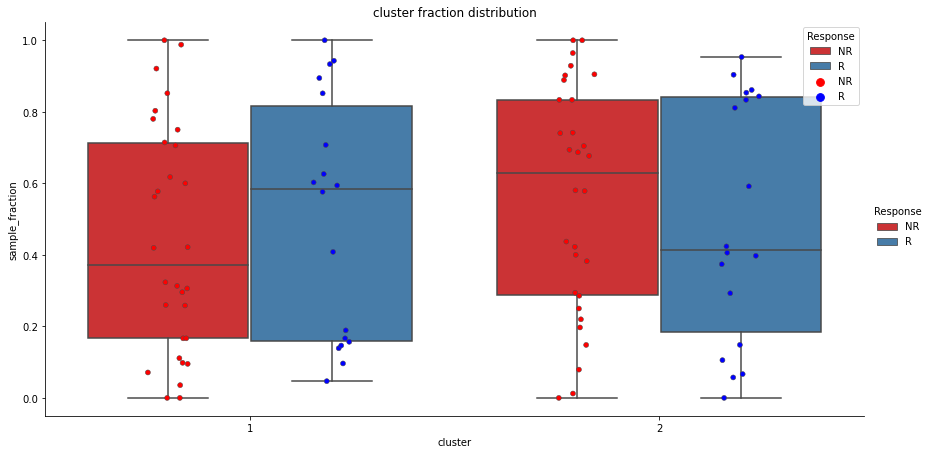

In [106]:
fig = plt.figure(figsize=(6, 3), dpi=80);
sns.reset_orig();
# full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
# full_sample_fractions_df = full_sample_fractions_df.sort_values('Cluster')
ax = sns.catplot(kind="box", x='cluster', y='sample_fraction', hue='Response', data=CD8_cluster_fraction, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution");
sns.stripplot(x='cluster', y='sample_fraction', hue='Response', data=CD8_cluster_fraction,
              jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

# 3. repeating the ranksum tests on treatments subgroups (2)


Question raised:
How to label pre/post of # M130 M132 M137 M163 in clinical table?


Divide the cutaneous patients into groups: 

A. Those who got only PD1 (NIVO), and then divide them to pre and post

B. Those who got IPI and NIVO, and then divide them to pre and post

Then, it's simply repeating the ranksum tests on these subgroups and see if the signal changes, not a big deal.


In [19]:
def therapy_translator(x):
    if not x or str(x) == 'nan':
        return 'nothing'
    x = str(x).lower()
    res=''
    if 'pembro' in x or 'pembo' in x or 'nivo' in x or 'apd' in x or 'pd1' in x:
        res += 'NIVO'
    if 'ipi' in x:
        res += ' + IPI'
        
    if res != '':
        return res

    elif 'enco' in x or 'd+t' in x:
        return 'other therapy'

    elif 'radiation' in x:
        return 'other therapy'

    elif 'carbo' in x or 'imatinib' in x or 'tmz' in x or 'tvec' in x or 'cdk4/6' in x:
        return 'other immune therapy'

    elif 'surgical ' in x or 'surgery ' in x or 'neodajuvant' in x:
        return 'other therapy'

    else:
        return 'other therapy'

In [20]:
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv'  # .xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH, engine='openpyxl').iloc[:71]
clinical_labels = pd.read_csv(CLINICAL_LABELS_PATH)
   

In [21]:
# take only cutaneous samples
cutaneous_melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['Melanoma type'] == 'Cutaneous']


# Convert response label mapping using clinical_label table
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
labels_mapping['R '] = 'R'
labels_mapping['PD (NR; for pembro) NR for d+t'] = 'NR'
cutaneous_melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
cutaneous_melanoma_clinical_data['response'] = cutaneous_melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])

# convert treatments
cutaneous_melanoma_clinical_data['treatment_before'] = cutaneous_melanoma_clinical_data['Therapy(ies) prior to biopsy'].apply(lambda rr: therapy_translator(rr))
cutaneous_melanoma_clinical_data['treatment_after'] = cutaneous_melanoma_clinical_data['Therapy after biopsy'].apply(lambda rr: therapy_translator(rr))


cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[['Patient id', 'treatment_before', 'treatment_after', 'Biopsy type (pre, post)', 'response']]
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data.response != 'not in use for now']

In [22]:

pre_post_translator = {'Pre': 'Pre', 'Post': 'Post', 'Post ': 'Post',
 'Post (pre chemo)': 'Post',
'Pre (ipi+nivo)': 'Pre', # M130, M153
 'Post (pembro) pre (enco+bini)':'Post',
'Pre (d+t)' : 'Post',
'Post (Nivo)': 'Post',
'Post (IPi Nivo)' : 'Post',
'nan' : 'Pre',
'Pre (adj)' : 'Pre', 
'Post (pembro)': 'Post'}


cutaneous_melanoma_clinical_data['pre/post'] = cutaneous_melanoma_clinical_data['Biopsy type (pre, post)'].apply(lambda x: pre_post_translator[str(x)])
cutaneous_melanoma_clinical_data.loc[cutaneous_melanoma_clinical_data['Patient id']=='M163', ['pre/post']] = 'Post'
cutaneous_melanoma_clinical_data.loc[cutaneous_melanoma_clinical_data['Patient id']=='M137', ['pre/post']] = 'Post'
cutaneous_melanoma_clinical_data.loc[cutaneous_melanoma_clinical_data['Patient id']=='M130', ['pre/post']] = 'Post'
cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']!='M132'].reset_index(drop=True).drop(columns=['Biopsy type (pre, post)'])


#### Divide the cutaneous patients into groups:

A. Those who got only PD1 (NIVO), and then divide them to pre and post

B. Those who got IPI and NIVO, and then divide them to pre and post

In [23]:
Pre_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['pre/post'] == 'Pre'].reset_index(drop=True)
Post_cutaneous_melanoma_clinical_data = cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['pre/post'] == 'Post'].reset_index(drop=True)

NIVO_Post_cutaneous_melanoma_clinical_data = Post_cutaneous_melanoma_clinical_data[Post_cutaneous_melanoma_clinical_data['treatment_before']=='NIVO']
IPI_NIVO_Post_cutaneous_melanoma_clinical_data = Post_cutaneous_melanoma_clinical_data[Post_cutaneous_melanoma_clinical_data['treatment_before']=='NIVO + IPI']
NIVO_Pre_cutaneous_melanoma_clinical_data = Pre_cutaneous_melanoma_clinical_data[Pre_cutaneous_melanoma_clinical_data['treatment_after']=='NIVO']
IPI_NIVO_Pre_cutaneous_melanoma_clinical_data = Pre_cutaneous_melanoma_clinical_data[Pre_cutaneous_melanoma_clinical_data['treatment_after']=='NIVO + IPI']


In [24]:
# IPI_NIVO_Post_cutaneous_melanoma_clinical_data

#### Repeating the ranksum tests on these subgroups and see if the signal changes, not a big deal.

In [25]:
IMMUNE_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/immune/summary/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
immune_clustering_mapping_barcodes = pd.read_csv(IMMUNE_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
immune_cluster_fraction = get_cluster_fraction_df(immune_clustering_mapping_barcodes)
immune_cluster_fraction = immune_cluster_fraction[immune_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
immune_cluster_fraction['Response'] = immune_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])

CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/summary/4.11.21/CD8_kmeans_integrated_4.11.21_clusters_mapping.csv'
CD8_clustering_mapping_barcodes = pd.read_csv(CD8_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
CD8_cluster_fraction = get_cluster_fraction_df(CD8_clustering_mapping_barcodes)
CD8_cluster_fraction = CD8_cluster_fraction[CD8_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
CD8_cluster_fraction['Response'] = CD8_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])


myeloid_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/myeloid/summary/4.11.21/myeloid_kmeans_integrated_4.11.21_clusters_mapping.csv'
myeloid_clustering_mapping_barcodes = pd.read_csv(myeloid_CLUSTERING_PATH).drop(columns=['Unnamed: 0'])
myeloid_cluster_fraction = get_cluster_fraction_df(myeloid_clustering_mapping_barcodes)
myeloid_cluster_fraction = myeloid_cluster_fraction[myeloid_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
myeloid_cluster_fraction['Response'] = myeloid_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])




In [26]:
all_groups = {'IPI_NIVO_pre':IPI_NIVO_Pre_cutaneous_melanoma_clinical_data,
 'IPI_NIVO_post':IPI_NIVO_Post_cutaneous_melanoma_clinical_data,
 'NIVO_pre':NIVO_Pre_cutaneous_melanoma_clinical_data,
 'NIVO_post':NIVO_Post_cutaneous_melanoma_clinical_data}


#### Immune clustering:

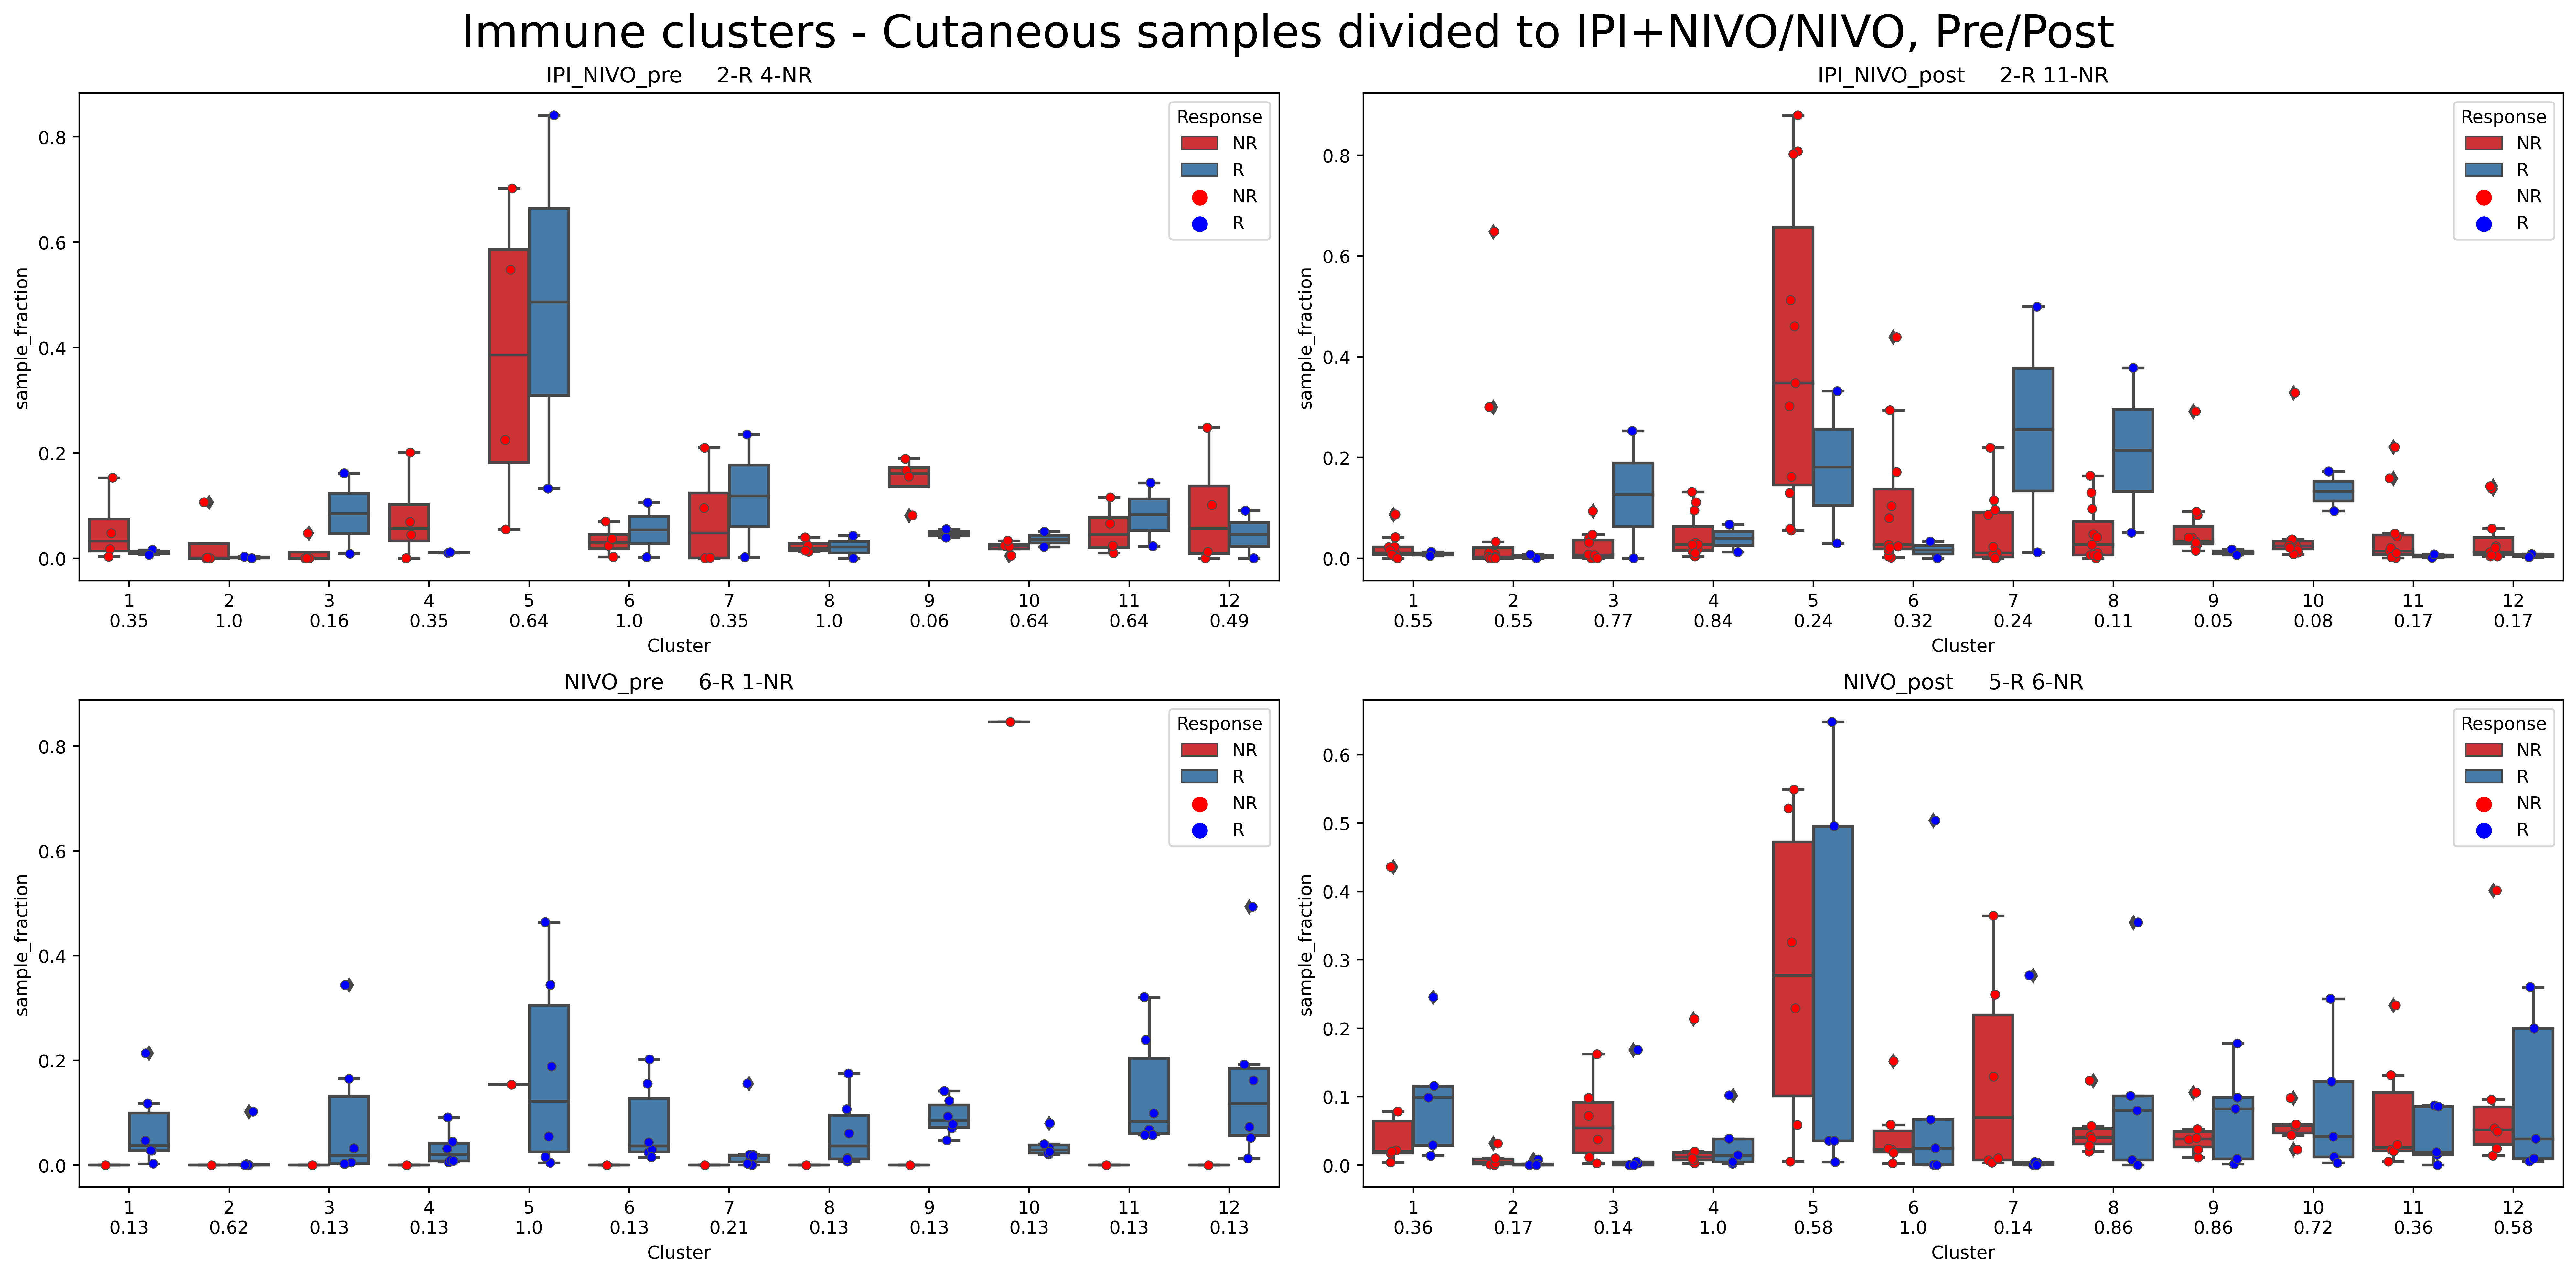

In [27]:
(fig,axes) = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

for idx, (group_name, group_df) in enumerate(all_groups.items()):
#     print(f'{group_name}:\n{group_df["response"].value_counts()}')
    group_fractions = immune_cluster_fraction[immune_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('Immune clusters - Cutaneous samples divided to IPI+NIVO/NIVO, Pre/Post', fontsize=25);
plt.tight_layout(pad=1)



#### CD8 clustering:

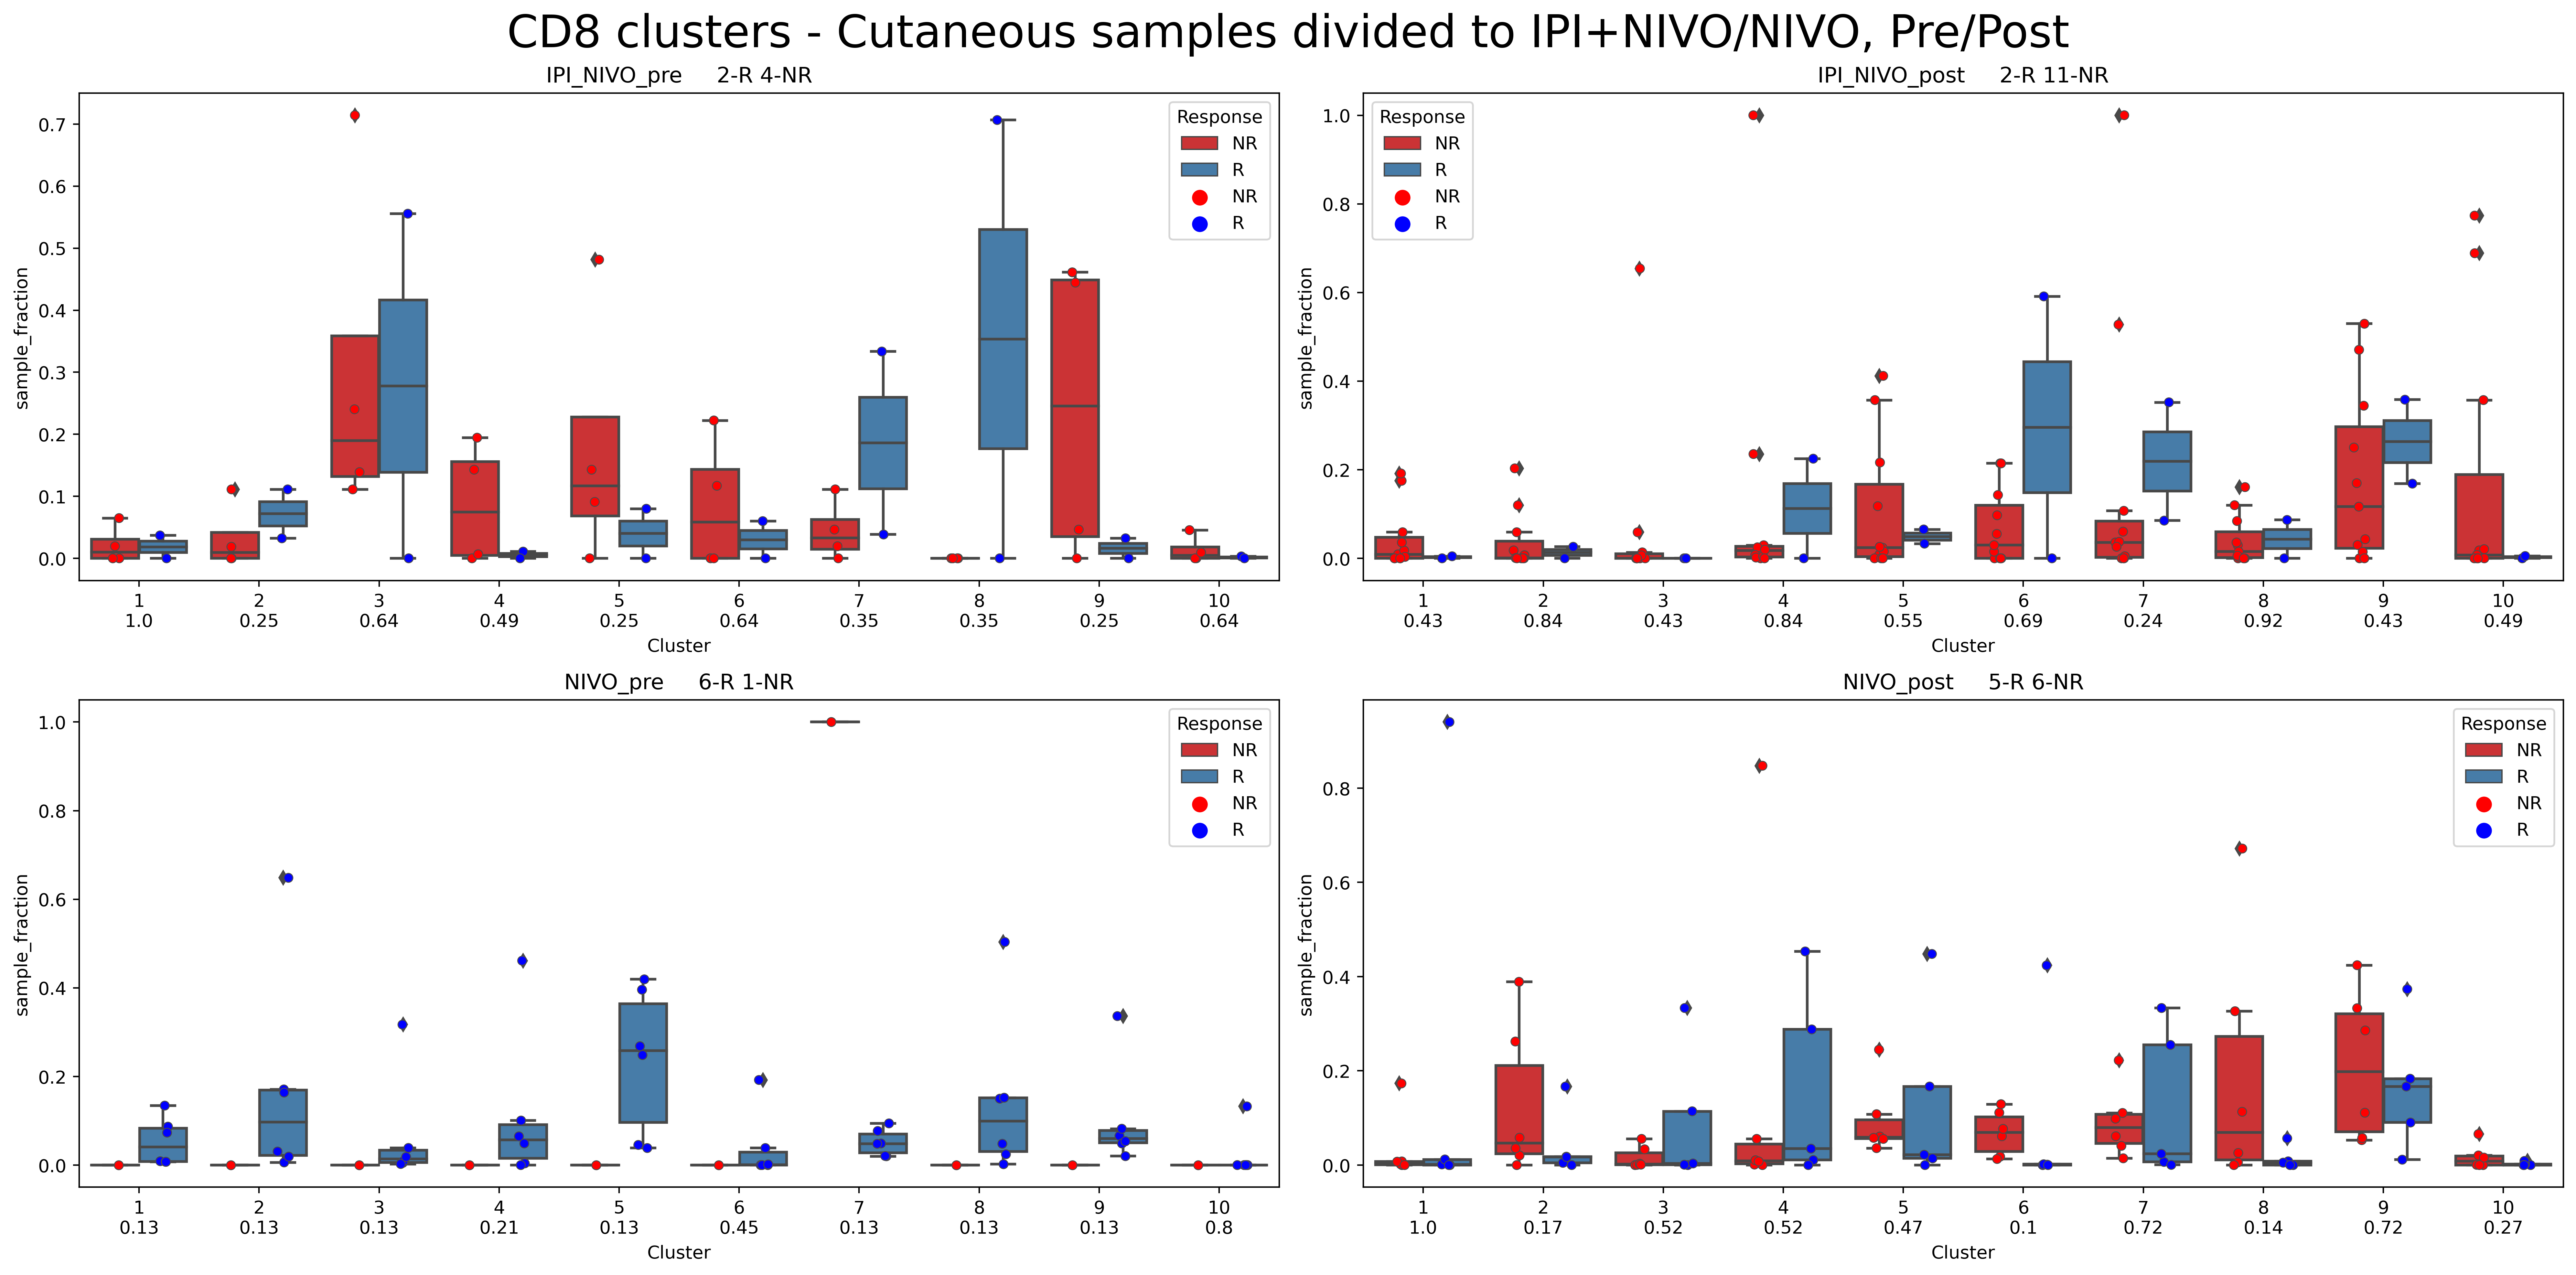

In [28]:
(fig,axes) = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = CD8_cluster_fraction[CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('CD8 clusters - Cutaneous samples divided to IPI+NIVO/NIVO, Pre/Post', fontsize=25);
plt.tight_layout(pad=1)

#### Myeloid clustering:

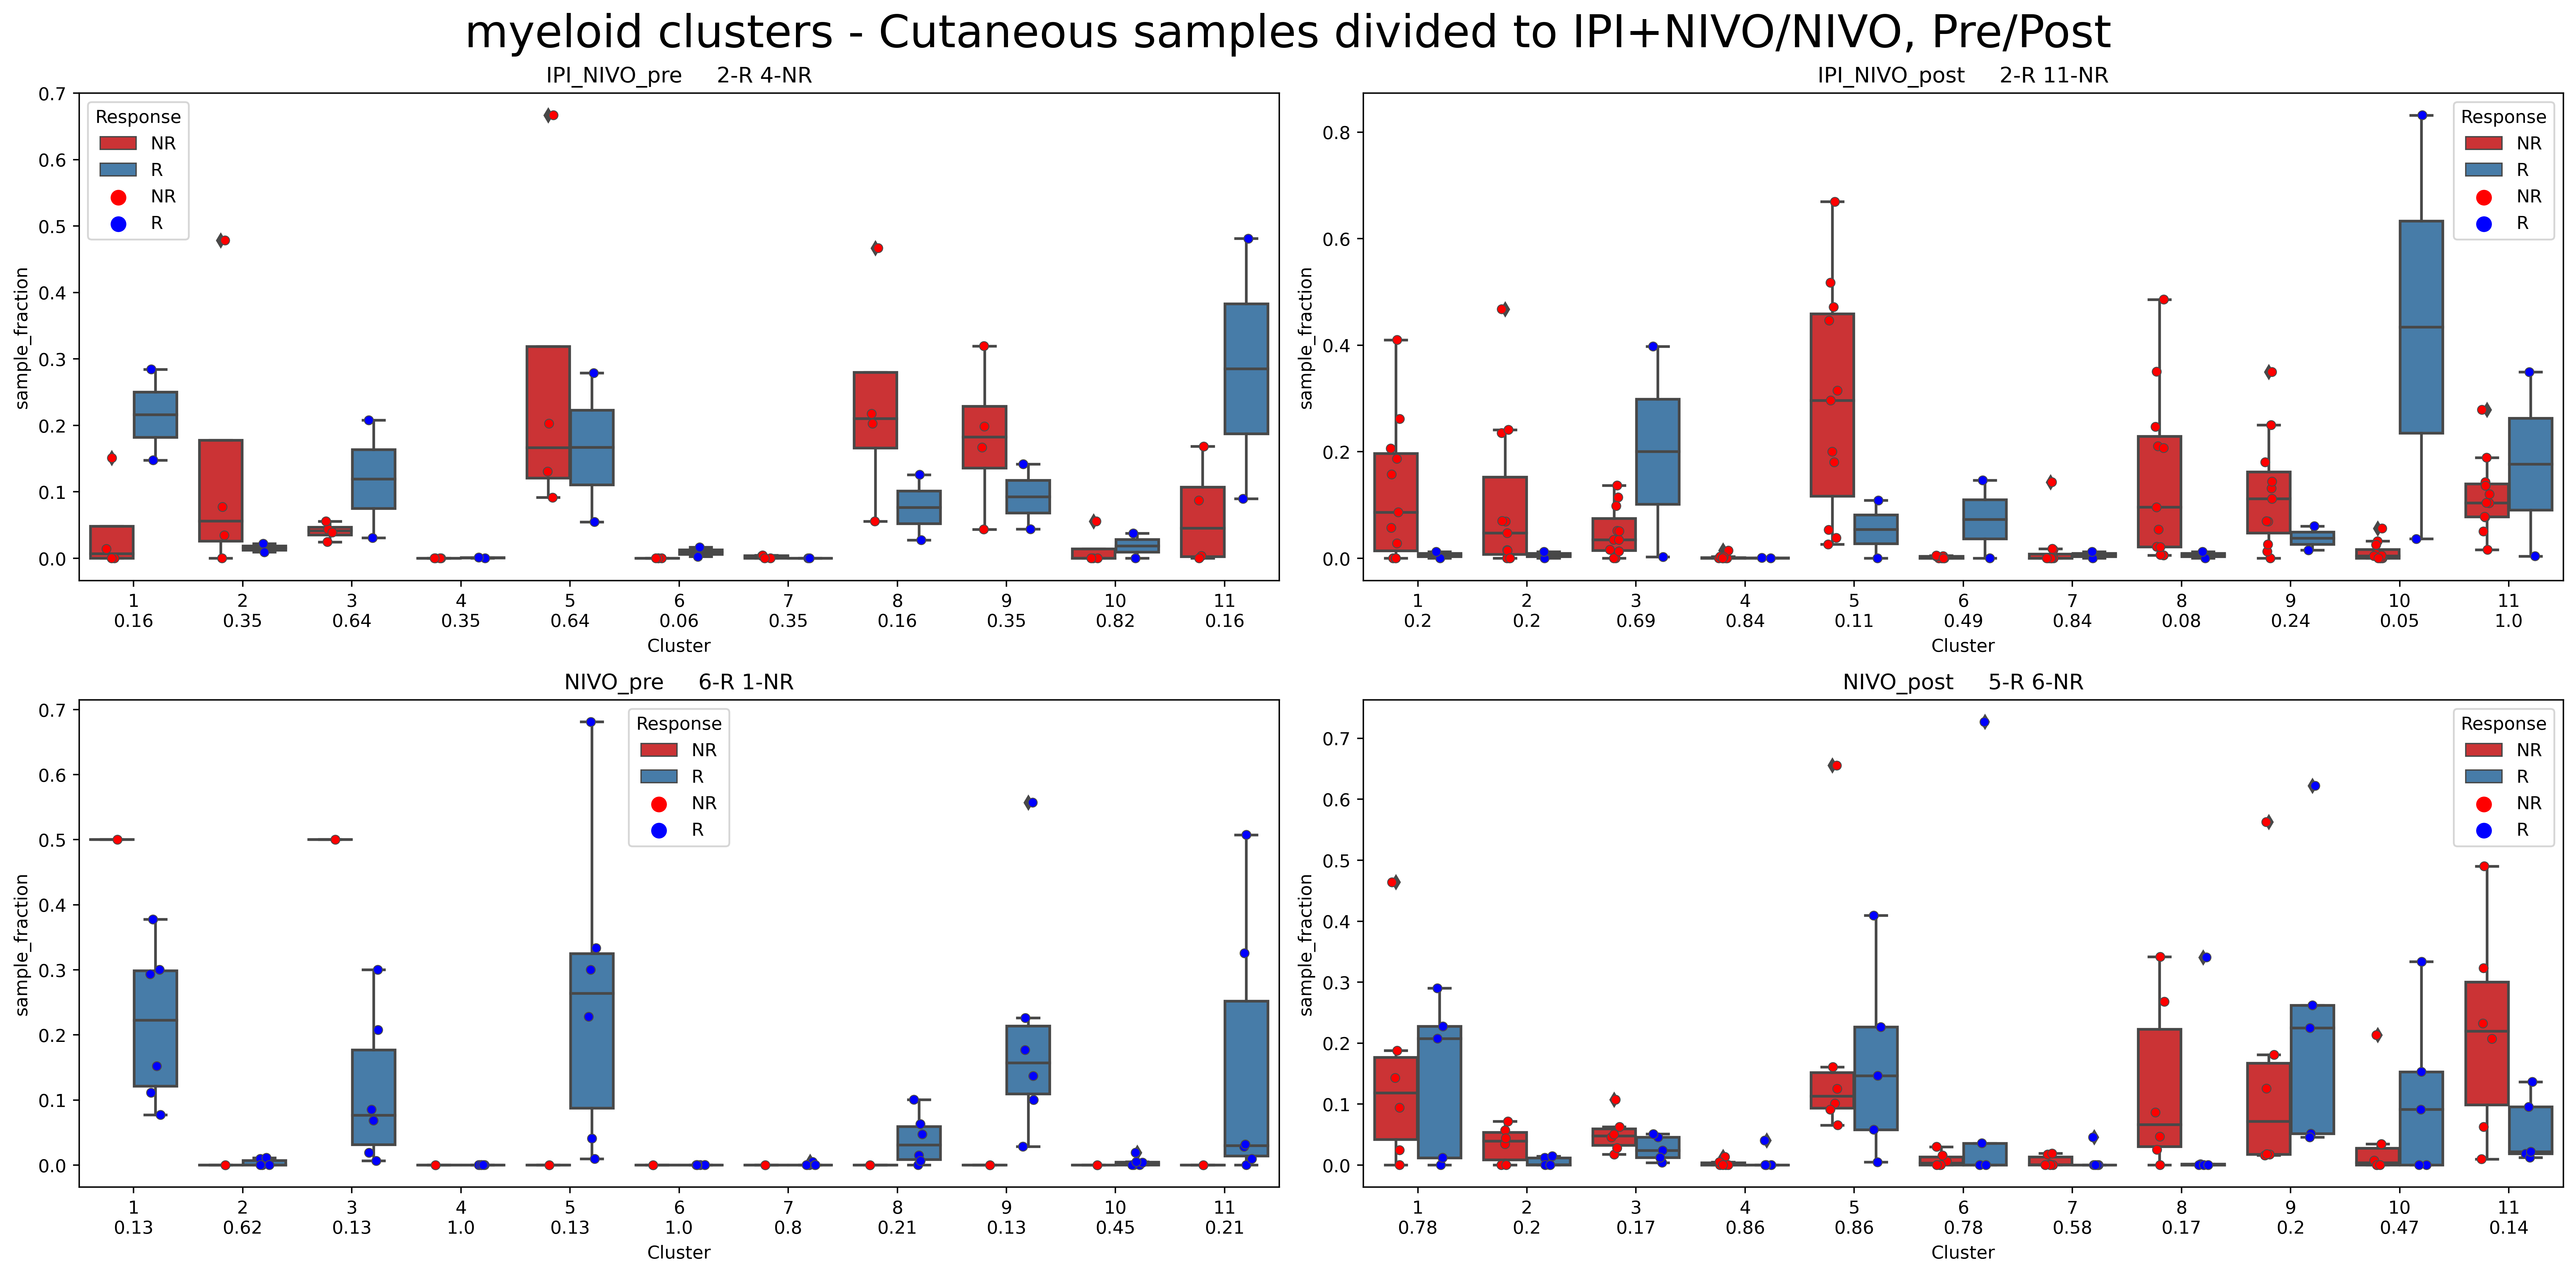

In [29]:
(fig,axes) = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = myeloid_cluster_fraction[myeloid_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('myeloid clusters - Cutaneous samples divided to IPI+NIVO/NIVO, Pre/Post', fontsize=25);
plt.tight_layout(pad=1)

#### Exhausted and Memory CD8 clusters:

In [34]:
exh_mem_CD8_CLUSTERING_PATH = r'/storage/md_keren/shitay/outputs/clustering/CD8/kmeans/cohort_16.3.22_run_29.4.22/barcode_mapping/kmeans_immune_cells_4k_genes_k_2_clusters_mapping.csv'
exh_mem_CD8_clustering_mapping_barcodes = pd.read_csv(exh_mem_CD8_CLUSTERING_PATH).drop(columns=['index'])
exh_mem_CD8_cluster_fraction = get_cluster_fraction_df(exh_mem_CD8_clustering_mapping_barcodes)
exh_mem_CD8_cluster_fraction = exh_mem_CD8_cluster_fraction[exh_mem_CD8_cluster_fraction['sample'].isin(cutaneous_melanoma_clinical_data['Patient id'])]
exh_mem_CD8_cluster_fraction['Response'] = exh_mem_CD8_cluster_fraction['sample'].apply(lambda x: cutaneous_melanoma_clinical_data[cutaneous_melanoma_clinical_data['Patient id']==x].response.iloc[0])

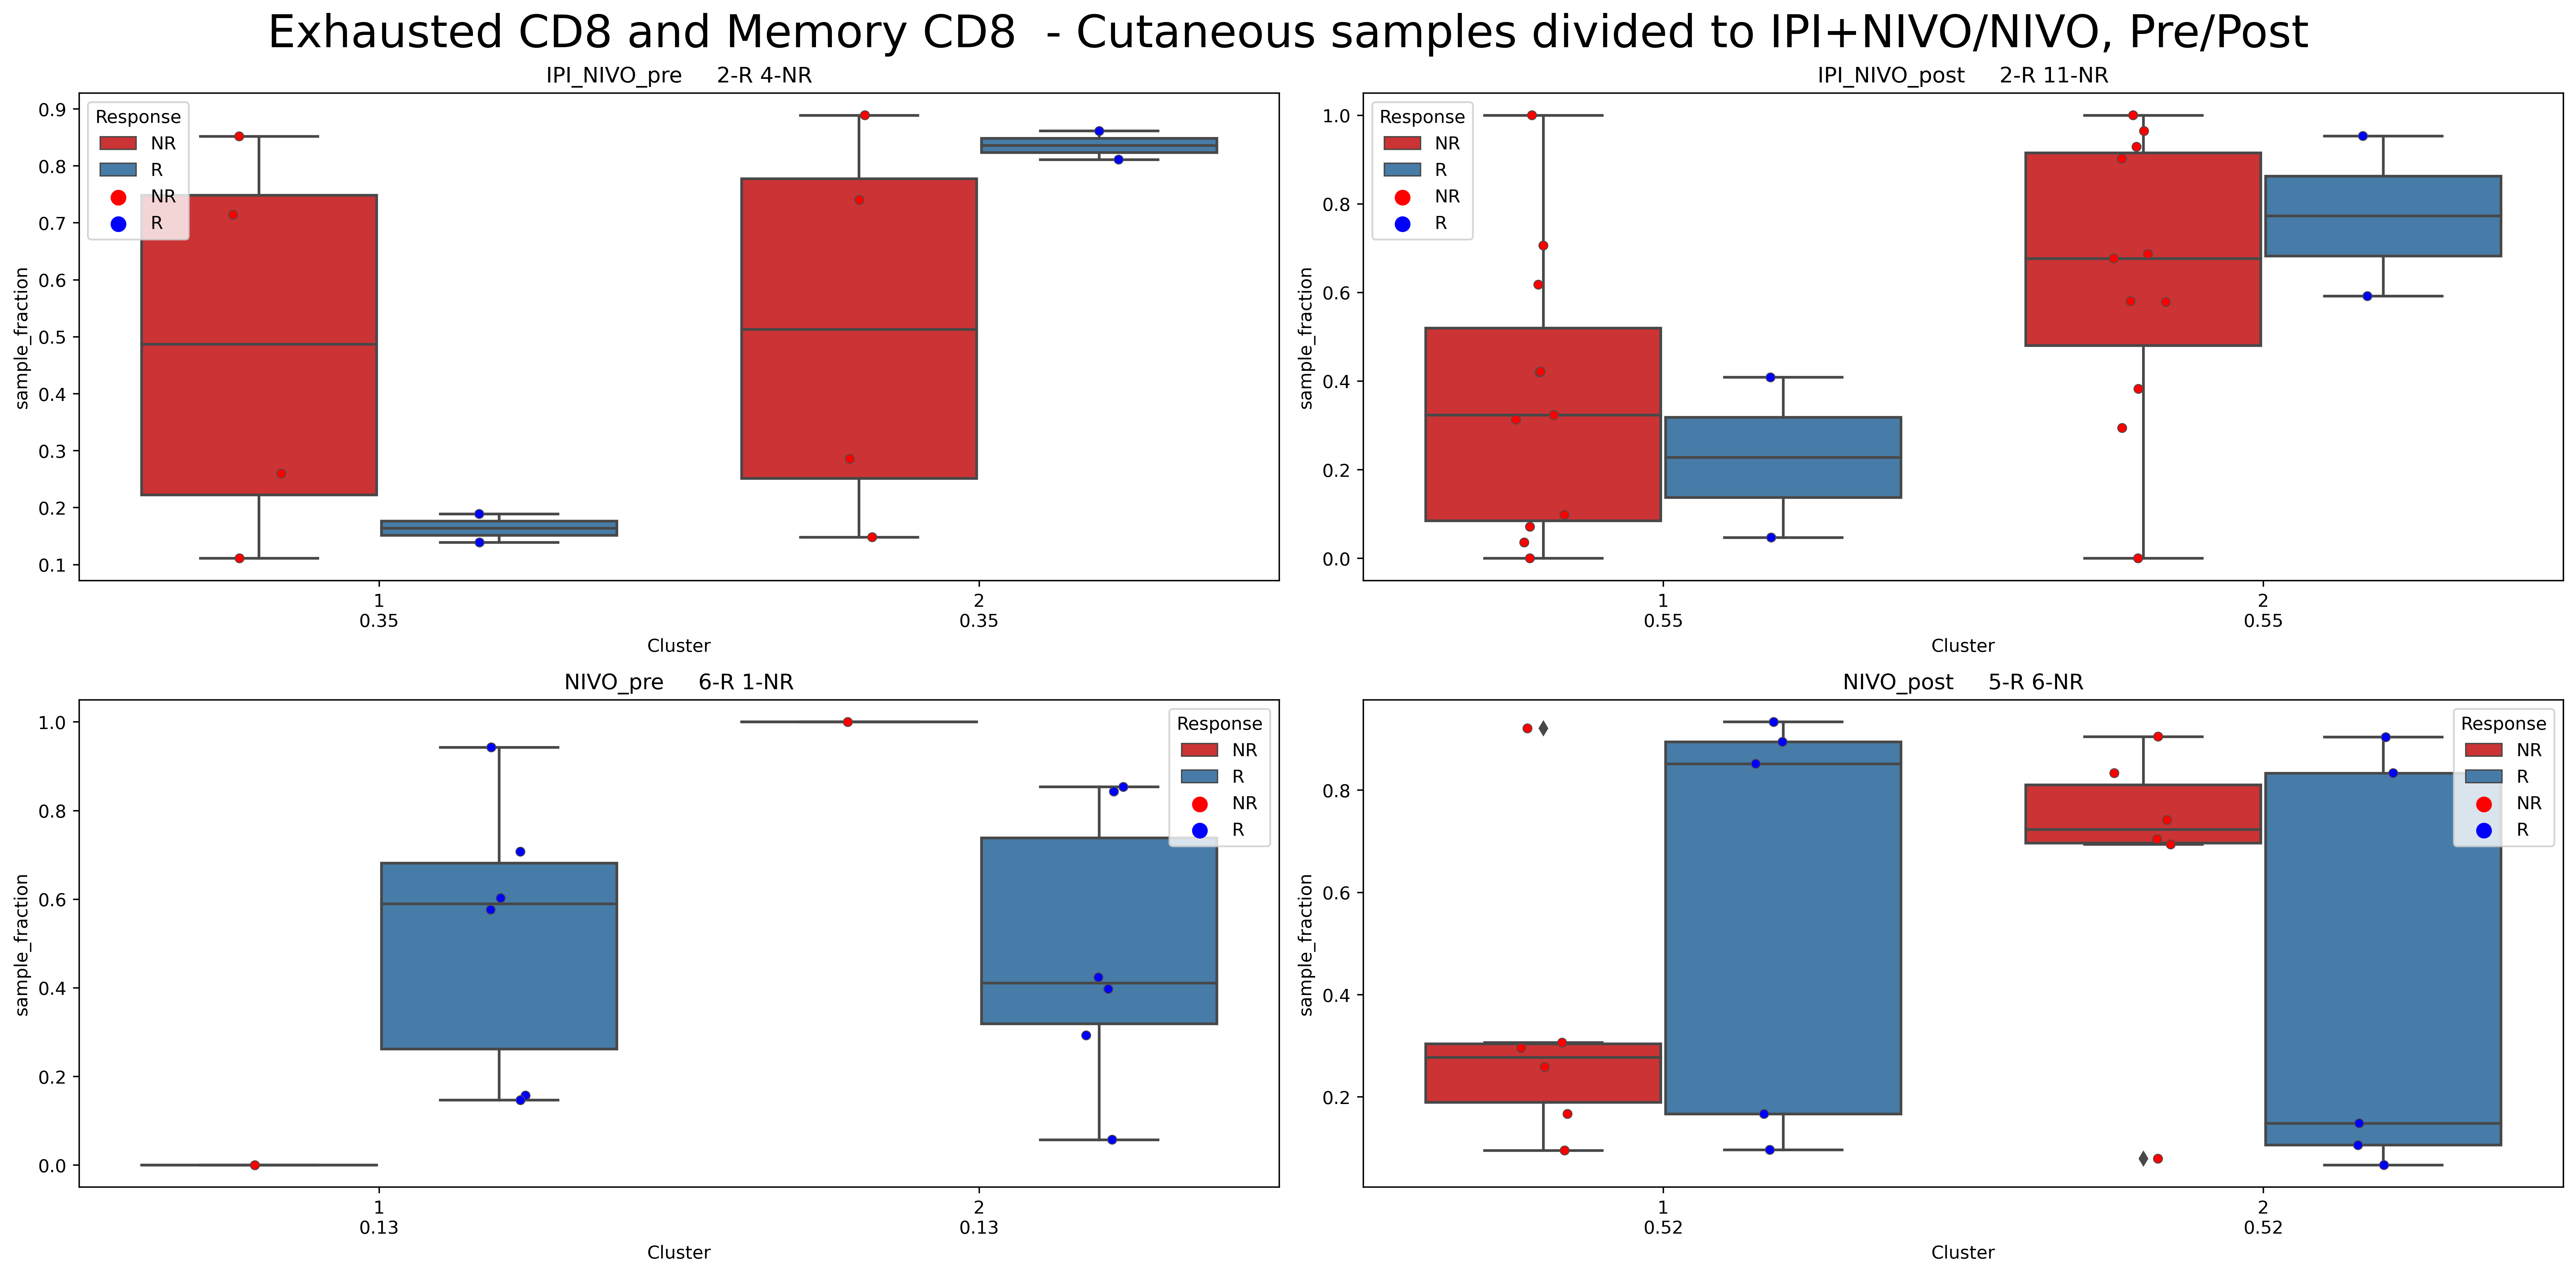

In [96]:
(fig,axes) = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.ravel()

for idx, (group_name, group_df) in enumerate(all_groups.items()):
    group_fractions = exh_mem_CD8_cluster_fraction[exh_mem_CD8_cluster_fraction['sample'].isin(group_df['Patient id'])]
    pvals, corrected_pvals = get_pvals(group_fractions)
    group_fractions['Cluster'] = group_fractions['cluster'].apply(lambda x: str(x)+f'\n{round(dict(pvals)[x],2)}')
    sns.boxplot(ax=axes[idx], x="Cluster", y="sample_fraction", hue='Response',  palette="Set1", data=group_fractions).set(title=group_name+'     '+str(group_df["response"].value_counts()["R"])+'-R ' + str(group_df["response"].value_counts()["NR"])+'-NR');
    sns.stripplot(ax=axes[idx],x='Cluster', y='sample_fraction', hue='Response', data=group_fractions,
                  jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});
    
fig.suptitle('Exhausted CD8 and Memory CD8  - Cutaneous samples divided to IPI+NIVO/NIVO, Pre/Post', fontsize=25);
plt.tight_layout(pad=1)

## 4. Conduct a robust test of differential expression by discovering and cross validation (3)


In [147]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22/cohort_normalized_16.3.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)
immune_cohort = cohort.filter_cells_by_property('is_immune', True)

In [148]:
# DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/response_immune_markers.xlsx'
# DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/non_response_immune_markers.xlsx'
# DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/response_immune_markers.xlsx'
# DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/non_response_immune_markers.xlsx'

In [149]:
# melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM) #
melanoma_clinical_data = get_clinical_data(71, ICI=True)# after_biopsy='ICI')
melanoma_clinical_data = melanoma_clinical_data#.set_index('Patient id', drop=True)
melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['response']!='not in use for now']
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
# display(melanoma_clinical_data.head(20))
melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv
Num of samples in table is 49


NR    31
R     18
Name: response, dtype: int64

In [150]:
train_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'].sample(14)
train_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'].sample(24)
test_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'][~melanoma_clinical_data[melanoma_clinical_data['response']=='R']['Patient id'].isin(train_r['Patient id'])]
test_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'][~melanoma_clinical_data[melanoma_clinical_data['response']=='NR']['Patient id'].isin(train_nr['Patient id'])]

In [151]:
def split_to_train_and_test(melanoma_clinical_data, n_train_R=14, n_train_NR=24):
    train_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'].sample(n_train_R)
    train_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'].sample(n_train_NR)
    test_r = melanoma_clinical_data[melanoma_clinical_data['response']=='R'][~melanoma_clinical_data[melanoma_clinical_data['response']=='R']['Patient id'].isin(train_r['Patient id'])]
    test_nr = melanoma_clinical_data[melanoma_clinical_data['response']=='NR'][~melanoma_clinical_data[melanoma_clinical_data['response']=='NR']['Patient id'].isin(train_nr['Patient id'])]
    return train_r, train_nr, test_r, test_nr

def find_overlap_markers(subcohort, train_r, train_nr, test_r, test_nr):
    # cohort of sets
    train_r_cohort = subcohort[[sample in train_r['Patient id'].tolist() for sample in subcohort.samples]]
    train_nr_cohort = subcohort[[sample in train_nr['Patient id'].tolist() for sample in subcohort.samples]]
    test_r_cohort = subcohort[[sample in test_r['Patient id'].tolist() for sample in subcohort.samples]]
    test_nr_cohort = subcohort[[sample in test_nr['Patient id'].tolist() for sample in subcohort.samples]]

    # differential expression analysis - train set
    train_r_markers = find_satisfying_list_of_markers_in_cluster(train_r_cohort, train_nr_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_markers=50)
    train_nr_markers = find_satisfying_list_of_markers_in_cluster(train_nr_cohort, train_r_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_markers=50)
    # differential expression analysis - test set
    test_r_markers = find_satisfying_list_of_markers_in_cluster(test_r_cohort, test_nr_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_markers=50)
    test_nr_markers = find_satisfying_list_of_markers_in_cluster(test_nr_cohort, test_r_cohort, log_FC_threshold=0.5, pval_threshold=0.05, 
                                                                  min_pct=0.1, min_diff_pct=0.1, min_markers=50)

    # build overlap table
    overlap_markers_counting_table = pd.DataFrame(columns=['top', '# R markers in overlap', '# NR markers in overlap', '# R markers in train', 
                                                           '# NR markers in train', '# R markers in test', '# NR markers in test', 'overlap R markers', 'overlap NR markers'])
    for n_of_markers in [20, 50, 100, 200]:
        R_overlap = intersection_of_lists(train_r_markers['gene names'].iloc[:n_of_markers], test_r_markers['gene names'].iloc[:n_of_markers])
        NR_overlap = intersection_of_lists(train_nr_markers['gene names'].iloc[:n_of_markers], test_nr_markers['gene names'].iloc[:n_of_markers])

        overlap_markers_counting_table = overlap_markers_counting_table.append(pd.DataFrame([[n_of_markers, len(R_overlap), len(NR_overlap),
                                                                                              min(len(train_r_markers), n_of_markers), min(len(train_nr_markers), n_of_markers), 
                                                                                              min(len(test_r_markers), n_of_markers), min(len(test_nr_markers), n_of_markers),
                                                                                             R_overlap, NR_overlap]], columns=overlap_markers_counting_table.columns))
    overlap_markers_counting_table = overlap_markers_counting_table.reset_index(drop=True)
    
    return overlap_markers_counting_table, train_r_markers, train_nr_markers, test_r_markers, test_nr_markers

#### split clinical table to test and train:

In [152]:
train_r, train_nr, test_r, test_nr = split_to_train_and_test(melanoma_clinical_data)

In [153]:
# melanoma_clinical_data.iloc[:36]['response'].value_counts()
print(f'train_r: {len(train_r)} samples')
print(f'train_nr: {len(train_nr)} samples')
print(f'test_r: {len(test_r)} samples')
print(f'test_nr: {len(test_nr)} samples')

train_r: 14 samples
train_nr: 24 samples
test_r: 4 samples
test_nr: 7 samples


#### see overlap of markers in immune cells:

In [154]:
overlap_immune_markers_counting_table, train_r_immune_markers, train_nr_immune_markers, test_r_immune_markers, test_nr_immune_markers = find_overlap_markers(immune_cohort, train_r, train_nr, test_r, test_nr)

In [155]:
overlap_immune_markers_counting_table

,top,# R markers in overlap,# NR markers in overlap,# R markers in train,# NR markers in train,# R markers in test,# NR markers in test,overlap R markers,overlap NR markers
0,20,0,0,20,20,20,20,[],[]
1,50,0,1,50,50,50,50,[],[HLA-G]
2,100,0,2,51,72,62,100,[],"[HLA-G, CLIC3]"
3,200,0,2,51,72,62,200,[],"[HLA-G, CLIC3]"


#### see overlap of markers in tumor cells:

In [156]:
overlap_tumor_markers_counting_table, train_r_tumor_markers, train_nr_tumor_markers, test_r_tumor_markers, test_nr_tumor_markers = find_overlap_markers(tumor_cohort, train_r, train_nr, test_r, test_nr)

In [157]:
overlap_tumor_markers_counting_table

,top,# R markers in overlap,# NR markers in overlap,# R markers in train,# NR markers in train,# R markers in test,# NR markers in test,overlap R markers,overlap NR markers
0,20,1,1,20,20,20,20,[CTAG2],[BCAN]
1,50,5,5,50,50,50,50,"[ENTHD1, HLA-DRA, MAGEC2, CTAG2, HLA-DRB1]","[HIST1H1C, MFAP2, BCAN, CDKN2A, TFPI2]"
2,100,11,10,100,67,100,100,"[HLA-DRA, DCT, TNFSF13B, MAGEC2, HLA-DRB1, ENT...","[HIST1H1C, HIST1H2BK, PRDX1, MFAP2, TMC6, BCAN..."
3,200,27,13,200,67,200,200,"[HLA-DRA, MFGE8, DCT, EVA1A, POLR2J, VKORC1, P...","[HIST1H1C, HIST1H2BK, PRDX1, MFAP2, TMC6, BCAN..."


## 5. identify the % of organ cells in each biopsy (5)


In [42]:
# melanoma_clinical_data = get_constant_cohort(CLINICAL_TABLE_NUM) #
melanoma_clinical_data = get_clinical_data(71, additional_features=['Biopsy site'])# after_biopsy='ICI')
melanoma_clinical_data = melanoma_clinical_data#.set_index('Patient id', drop=True)
# melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['response']!='not in use for now']
print(f'Num of samples in table is {len(melanoma_clinical_data)}')
# display(melanoma_clinical_data.head(20))
melanoma_clinical_data['response'].value_counts()

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv
Num of samples in table is 71


NR                    32
R                     20
not in use for now    19
Name: response, dtype: int64

In [65]:
# sort_dic(dict(Counter(melanoma_clinical_data['Biopsy site'])), descending=True, by_key=False)

In [62]:
y = melanoma_clinical_data['Biopsy site'].apply(lambda x: 'LN' if ('LN' in str(x) or 'lymph node' in str(x).lower()) else x)
y = y.apply(lambda x: 'ovary' if ('ovary' in str(x).lower()) else x)
y = y.apply(lambda x: 'Liver' if ('liver' in str(x).lower()) else x)
y = y.apply(lambda x: 'Lung' if ('lung' in str(x).lower()) else x)
sort_dic(dict(Counter(y)), descending=True, by_key=False)

{'LN': 21,
 'Liver': 4,
 'Lung': 4,
 'Craniotomy': 4,
 'Thoracentesis': 3,
 nan: 3,
 'Endoscopy': 2,
 'Vulva (primary)': 2,
 'Peritoneal fluid': 2,
 'Right thigh (leg)': 2,
 'ovary': 2,
 'Left distal femur curettage': 1,
 'Left foot': 1,
 'Spine met (NR)': 1,
 'Small bowel met': 1,
 'Penis': 1,
 'Abdominal wall (soft tissue)': 1,
 'Right heel (bone biopsy)': 1,
 'Left popliteal fossa (back on the knee)': 1,
 'Right mesentery mass core biopsy': 1,
 'Spleen': 1,
 'Bladder (met)': 1,
 'Skin (primary) cheek': 1,
 'Right chest core needle biopsy': 1,
 'Right inguinal lymphadenectomy': 1,
 'Frontal lobe met': 1,
 'Right breast': 1,
 'Craniotomy- right frontal lesion': 1,
 'colonoscopy': 1,
 'Left shoulder': 1,
 'Right foot': 1,
 'Paracentesis (pelvis area)': 1,
 'Leg resection': 1}

## 6. plot a histogram of the number of T-cells; Myeloids and B-cells for example across the entire cohort (6)


In [3]:
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/16.3.22/cohort_normalized_16.3.22_protein_coding_genes.pkl'
cohort = pickle.load(open(COHORT_PATH, 'rb'))

In [4]:
from anndata import AnnData
ann_cohort = cohort.convert_to_AnnData()
# AnnData

In [82]:
cohort_df = ann_cohort.obs.copy()

In [88]:
cohort_df['T cells'] = data_df.cell_type_list.apply(lambda x: 'T cells' in x)
cohort_df['B cells'] = data_df.cell_type_list.apply(lambda x: 'B cells' in x)

#### Builds cohort_dfs of % and #:

In [107]:
proportions_cohort_df = cohort_df.groupby('sample').agg(immune=('is_immune', 'mean'), 
                                                         stromal=('is_stromal', 'mean'), 
                                                         tumor=('is_cancer', 'mean'))

amounts_cohort_df = cohort_df.groupby('sample').agg(immune=('is_immune', 'sum'), 
                                                     stromal=('is_stromal', 'sum'), 
                                                     tumor=('is_cancer', 'sum'), 
                                                     lymphoid=('is_lymphoid', 'sum'), 
                                                     myeloid=('is_myeloid', 'sum'),
                                                     T_cells=('T cells', 'sum'),
                                                     B_cells=('B cells', 'sum'))

#### % of cell-type in sample distribution:

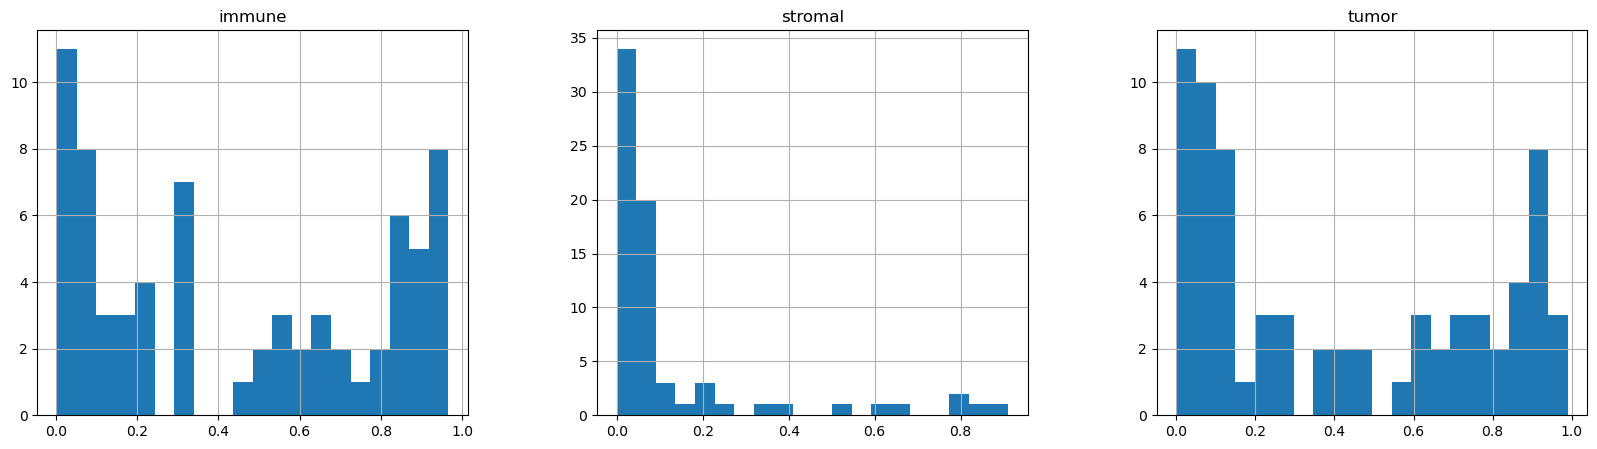

In [135]:
(fig,axes) = plt.subplots(1,3, figsize=(20, 5))
axes = axes.ravel()

for idx, col in enumerate(proportions_cohort_df.columns):
    proportions_cohort_df.hist(column = col, bins = 20, ax=axes[idx])

#### # of cell-type in sample distribution:

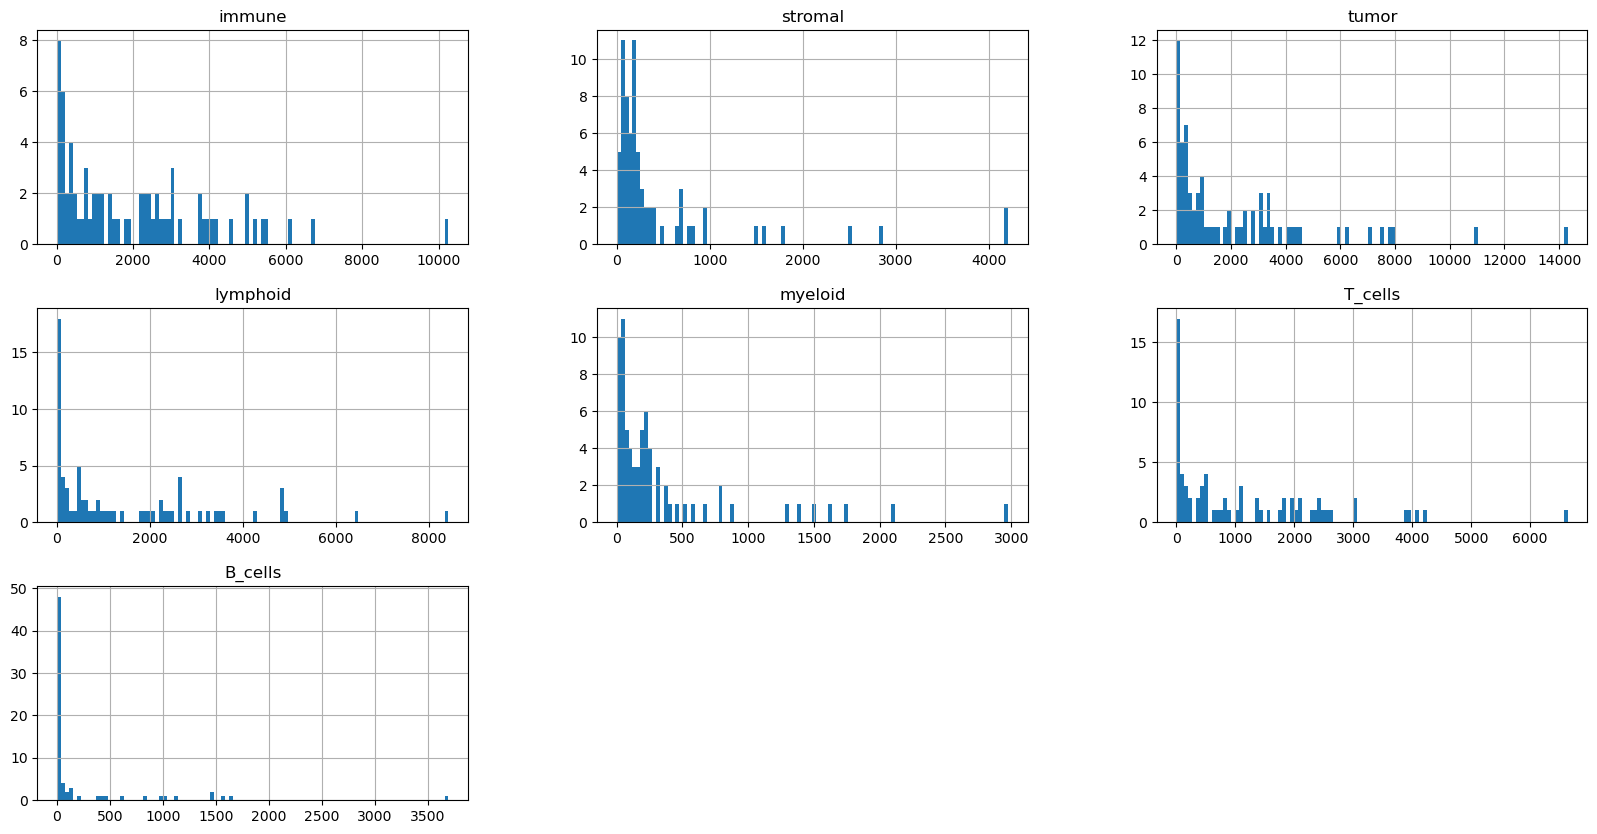

In [106]:
(fig,axes) = plt.subplots(3, 3, figsize=(20, 10))
axes = axes.ravel()

for idx, col in enumerate(amounts_cohort_df.columns):
    amounts_cohort_df.hist(column = col, bins = 100, ax=axes[idx])
    
    
if len(amounts_cohort_df.columns)%3>0:
    for i in range(3-len(summary_cohort_df.columns)%3, 0, -1):
        axes[-i].remove();

#### DFs

In [145]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
amounts_cohort_df

,immune,stromal,tumor,lymphoid,myeloid,T_cells,B_cells
sample,,,,,,,
M100,178,52,2817,104,53,97,3
M101,775,2842,562,471,221,463,10
M102,358,682,14320,258,47,238,11
M103,172,1488,102,129,24,129,2
M104,116,953,1908,65,30,63,1
...,...,...,...,...,...,...,...
M172,4138,257,2,3598,84,2095,1455
M173,2724,194,397,2441,151,1849,446
M97,1126,211,2002,750,200,700,4


In [144]:
proportions_cohort_df.sort_values('immune')

,immune,stromal,tumor
sample,,,
M123,0.002813,0.910625,0.086561
M133,0.009543,0.000227,0.990229
M157,0.012785,0.000000,0.987215
M127,0.014191,0.062046,0.923762
M108,0.018362,0.074153,0.907486
...,...,...,...
M139,0.949451,0.025092,0.025458
M140,0.951969,0.014618,0.033413
M131,0.953523,0.019740,0.026737


In [143]:
# proportions_cohort_df[proportions_cohort_df.immune<0.05]

## 7. Comparing responder/non-responder immune markers with smartseq2 study (7)


In [229]:
SMARTSEQ_MARKERS_PATH = r'/storage/md_keren/shitay/Data/smart_seq/tables/Discriminative genes in R and NR- smartseq.xlsx'
DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/response_immune_markers.xlsx'
DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/integrated_cohort_4.11.21/non_response_immune_markers.xlsx'
# DROPLET_R_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/response_immune_markers.xlsx'
# DROPLET_NR_MARKERS_PATH= r'/storage/md_keren/shitay/outputs/response_analysis/cohort_26.6.21/non_response_immune_markers.xlsx'

############################
smartseq_markers = pd.read_excel(SMARTSEQ_MARKERS_PATH)
r_smartseq_markers = smartseq_markers[smartseq_markers['mean exp in R'] > smartseq_markers['mean exp in NR']].iloc[::-1]
nr_smartseq_markers = smartseq_markers[smartseq_markers['mean exp in NR'] > smartseq_markers['mean exp in R']]

droplet_R_markers = pd.read_excel(DROPLET_R_MARKERS_PATH).drop(columns=['Unnamed: 0'])
droplet_NR_markers = pd.read_excel(DROPLET_NR_MARKERS_PATH).drop(columns=['Unnamed: 0'])

In [230]:
# pd.set_option('display.max_rows', 10)
# print(f'NR immune smartseq markers:')
# display(nr_smartseq_markers.head(5))
# print(f'R immune smartseq markers:')
# display(r_smartseq_markers.head(5))

In [232]:
overlap_markers_counting_table = pd.DataFrame(columns=['top', '# R markers in overlap', '# NR markers in overlap', '# R markers in droplet', 
                                                       '# NR markers in droplet', '# R markers in smartseq', '# NR markers in smartseq', 'overlap R markers', 'overlap NR markers'])
for n_of_markers in [20, 50, 100, 200]:
    R_overlap = intersection_of_lists(droplet_R_markers['gene names'].iloc[:n_of_markers], r_smartseq_markers['GeneName'].iloc[:n_of_markers])
    NR_overlap = intersection_of_lists(droplet_NR_markers['gene names'].iloc[:n_of_markers], nr_smartseq_markers['GeneName'].iloc[:n_of_markers])
    
    overlap_markers_counting_table = overlap_markers_counting_table.append(pd.DataFrame([[n_of_markers, len(R_overlap), len(NR_overlap),
                                                                                          min(len(droplet_R_markers), n_of_markers), min(len(droplet_NR_markers), n_of_markers), 
                                                                                          min(len(r_smartseq_markers), n_of_markers), min(len(nr_smartseq_markers), n_of_markers),
                                                                                         R_overlap, NR_overlap]], columns=overlap_markers_counting_table.columns))
overlap_markers_counting_table.reset_index(drop=True)

,top,# R markers in overlap,# NR markers in overlap,# R markers in droplet,# NR markers in droplet,# R markers in smartseq,# NR markers in smartseq,overlap R markers,overlap NR markers
0,20,0,1,20,20,7,20,[],[CCL3]
1,50,1,3,35,50,7,50,[SELL],"[CD63, GZMH, CCL3]"
2,100,1,11,35,100,7,100,[SELL],"[GZMH, PRF1, CCL4, CXCR6, CCL3, GLIPR2, BHLHE4..."
3,200,1,23,35,200,7,200,[SELL],"[GZMH, PRF1, ZYX, CCL4, NUCB1, CXCR6, MDH2, CC..."


# DEBUG

In [232]:
fig = plt.figure(figsize=(6, 3), dpi=80);
# sns.reset_orig();
# # full_sample_fractions_df['cluster'] = full_sample_fractions_df['Cluster'].apply(lambda x: get_coorected_label(x, dict(corrected_pvals)))
# # full_sample_fractions_df = full_sample_fractions_df.sort_values('Cluster')
# ax = sns.catplot(kind="box", x='cluster', y='sample_fraction', hue='Response', data=group_fractions, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution");
# sns.stripplot(x='cluster', y='sample_fraction', hue='Response', data=group_fractions,
#               jitter=True, dodge=True, linewidth=0.5, palette={'NR':'r', 'R':'b'});

<Figure size 480x240 with 0 Axes>

In [228]:
# overlap of markers
for n_of_markers in [20, 50, 100, 200]:
    print(f'Taking top {n_of_markers} markers:')
    R_overlap = intersection_of_lists(droplet_R_markers['gene names'].iloc[:n_of_markers], r_smartseq_markers['GeneName'].iloc[:n_of_markers])
    NR_overlap = intersection_of_lists(droplet_NR_markers['gene names'].iloc[:n_of_markers], nr_smartseq_markers['GeneName'].iloc[:n_of_markers])
    
    print(f'Number of markers in droplet_R_markers: {min(len(droplet_R_markers), n_of_markers)}')
    print(f'Number of markers in droplet_NR_markers: {min(len(droplet_NR_markers), n_of_markers)}')
    print(f'Number of markers in r_smartseq_markers: {min(len(r_smartseq_markers), n_of_markers)}')
    print(f'Number of markers in nr_smartseq_markers: {min(len(nr_smartseq_markers), n_of_markers)}')
    print()

    print(f'len of overlap R_overlap: {len(R_overlap)}')
    print(R_overlap)
    print(f'len of overlap NR_overlap: {len(NR_overlap)}')
    print(NR_overlap, end='\n\n######################################\n\n\n')
    

Taking top 20 markers:
Number of markers in droplet_R_markers: 20
Number of markers in droplet_NR_markers: 20
Number of markers in r_smartseq_markers: 7
Number of markers in nr_smartseq_markers: 20

len of overlap R_overlap: 0
[]
len of overlap NR_overlap: 1
['CCL3']

######################################


Taking top 50 markers:
Number of markers in droplet_R_markers: 35
Number of markers in droplet_NR_markers: 50
Number of markers in r_smartseq_markers: 7
Number of markers in nr_smartseq_markers: 50

len of overlap R_overlap: 1
['SELL']
len of overlap NR_overlap: 3
['CD63', 'GZMH', 'CCL3']

######################################


Taking top 100 markers:
Number of markers in droplet_R_markers: 35
Number of markers in droplet_NR_markers: 100
Number of markers in r_smartseq_markers: 7
Number of markers in nr_smartseq_markers: 100

len of overlap R_overlap: 1
['SELL']
len of overlap NR_overlap: 11
['GZMH', 'PRF1', 'CCL4', 'CXCR6', 'CCL3', 'GLIPR2', 'BHLHE40', 'IFNG', 'GZMB', 'CTSC', 'C

In [190]:
def therapy_IPI_transletror(x):
    if not x or str(x)=='nan':
        return 'nothing'
    x = str(x).lower()
    if 'ipi' in x and 'nivo' in x:
        return 'ICI'
    else: return 'other therapy'

n_samples=71
ICI=None
melanoma_type=None
prior_biopsy=None
after_biopsy=None
only_metastasis_sample=False
response=None
therapy_translator=therapy_ICI_translator
additional_features = ['Genotype ']

#  Loads xlsx files
print(f'Using clinical table in path:\n {MELANOMA_CLINICAL_DATA_PATH}\n\nand labels:\n{CLINICAL_LABELS_PATH}')
original_melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH, engine='openpyxl')
melanoma_clinical_data = original_melanoma_clinical_data.copy()
clinical_labels = pd.read_csv(CLINICAL_LABELS_PATH)
# takes only first 71 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:n_samples][
    ['Patient id', 'Clinical response', 'Melanoma type', 'Therapy(ies) prior to biopsy', 'Therapy after biopsy',
     'Primary=1; Metastasis=0', 'Genotype ']]
# fill Nans
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].fillna('??')
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
# Take only samples that are metastasis (if requested)
if only_metastasis_sample:
    melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['Primary=1; Metastasis=0'] != 1]
melanoma_clinical_data = melanoma_clinical_data.drop(columns='Primary=1; Metastasis=0')
# Convert response label mapping using clinical_label table
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}
labels_mapping['R '] = 'R'
labels_mapping['PD (NR; for pembro) NR for d+t'] = 'NR'
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
# Convert melanoma type
melanoma_type_translate = {'Cutaneous': 'Cutaneous', 'Mucosal ': 'Mucosal', 'Uveal': 'other', 'UN primary': 'other',
                           'Acral': 'other', 'Unknown': 'other', '??': 'other'}
melanoma_clinical_data['Melanoma type'] = melanoma_clinical_data['Melanoma type'].apply(
    lambda rr: melanoma_type_translate[rr])
# Convert therapy prior/after biopsy
melanoma_clinical_data['prior to biopsy'] = melanoma_clinical_data['Therapy(ies) prior to biopsy'].apply(
    lambda x: therapy_translator(x))
melanoma_clinical_data['after biopsy'] = melanoma_clinical_data['Therapy after biopsy'].apply(
    lambda x: therapy_translator(x))
melanoma_clinical_data['ICI'] = (melanoma_clinical_data['prior to biopsy'] == 'ICI') | (
        melanoma_clinical_data['after biopsy'] == 'ICI')
melanoma_clinical_data = melanoma_clinical_data.drop(
    columns=['Therapy(ies) prior to biopsy', 'Therapy after biopsy', 'Clinical response'])
# Convert Genotype - save information only for BRAF: is BRAF mutated or not BRAF mutated
melanoma_clinical_data['BRAF'] = melanoma_clinical_data['Genotype '].astype(str).apply(lambda x: True if 'BRAF' in x else False)
melanoma_clinical_data = melanoma_clinical_data.drop(columns=['Genotype '])

if not ICI is None:
    melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['ICI'] == ICI]
if not after_biopsy is None:
    melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['after biopsy'] == after_biopsy]
if not prior_biopsy is None:
    melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['prior to biopsy'] == prior_biopsy]
if not melanoma_type is None:
    melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['Melanoma type'].isin(melanoma_type)]
if not response is None:
    melanoma_clinical_data = melanoma_clinical_data[melanoma_clinical_data['response'] == response]

for feature in additional_features:
    melanoma_clinical_data[feature] = melanoma_clinical_data['Patient id'].apply(lambda x: original_melanoma_clinical_data.set_index('Patient id').loc[x][feature])


melanoma_clinical_data.reset_index().drop(columns=['index'])

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/clinical_tables/Melanoma_clinical_data_3.22_unprotected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_tables/clinical_labels.csv


,Patient id,Melanoma type,response,prior to biopsy,after biopsy,ICI,BRAF,Genotype
0,M97,Cutaneous,R,nothing,ICI,True,False,TP63; DDR2; ATM; MAP2K1; HNF1A; TERT
1,M98,Cutaneous,R,ICI,other therapy,True,False,NaN
2,M99,Mucosal,NR,ICI,other immune therapy,True,False,"NF2, NRAS, CTNNB1 variants"
3,M100,Cutaneous,NR,ICI,nothing,True,False,"NRAS, TERT, RET, NF1, SMARCA4 variants"
4,M101,other,R,nothing,ICI,True,False,"TRET, TP53, NRAS variants"
...,...,...,...,...,...,...,...,...
66,M169,Cutaneous,R,nothing,ICI,True,False,NaN
67,M170,Cutaneous,not in use for now,nothing,nothing,False,False,NRAS
68,M171,Cutaneous,not in use for now,nothing,nothing,False,False,NaN
69,M172,Cutaneous,not in use for now,nothing,nothing,False,False,NaN
